In [1]:
import sys, os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 10]

spark = (
    SparkSession.builder.appName("PySpark Hive Session from Jupyter Notebook")
    .config(
        "spark.master",
        "spark://{}:{}".format("spark-master", "7077"),
    )
    .config(
        "spark.hadoop.hive.metastore.uris",
        "thrift://{}:{}".format("hive-metastore", "9083"),
    )
    .config("spark.sql.warehouse.dir", "/hive/warehouse/dir")
    .config("spark.executor.memory", "10g")
    .config("spark.executor.cores", "2")
#     .config("spark.cores.max", "2")
    .config("spark.executor.instances", "1")
    .config("spark.debug.maxToStringFields", "100")
    .enableHiveSupport()
    .getOrCreate()
)

23/10/27 14:06:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
######################
# Group by Minute
######################

bid_ask_real_per_minute_raw_df = spark.sql(
    """
        with avg_ask_quote_price_per_seqid as
        (
            select
                date_trunc('minute', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'ask'
            group by
                ts_create_utc,
                seqid
        ),
        avg_bid_quote_price_per_seqid as
        (
            select
                date_trunc('minute', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'bid'
            group by
                ts_create_utc,
                seqid
        ),
        close_price_per_minute as
        (
            select 
                date_trunc('minute', ts_create_utc) as ts,
                close as real_close_price
            from 
                crypto_raw.candles_minute
            where
                id = 'BTC_USDT'
                and ts_create_utc >= (select min(ts_create_utc) from crypto_raw.market_trade)
        )
        select
            bid.ts as ts,
            count(bid.avg_quote_price) as order_count,
            avg(bid.avg_quote_price) as bid_avg_quote_price,
            approx_percentile(bid.med_quote_price, 0.5) as bid_med_quote_price,
            avg(ask.avg_quote_price) as ask_avg_quote_price,
            approx_percentile(ask.med_quote_price, 0.5) as ask_med_quote_price,
            avg(_close.real_close_price) as real_close_price
        from 
            avg_bid_quote_price_per_seqid as bid
        left join 
            avg_ask_quote_price_per_seqid as ask
        on
            bid.ts = ask.ts
            and bid.seqid = ask.seqid
        left join
            close_price_per_minute as _close
        on
            bid.ts = _close.ts
        group by 
            1
        order by 
            1
    """
)


In [5]:
# bid_ask_real_per_minute_df = bid_ask_real_per_minute_raw_df \
#     .orderBy(['ts']) \
#     .where(bid_ask_real_per_minute_raw_df['ts'] >= '2023-10-01') \
#     .toPandas()

bid_ask_real_per_minute_df

,ts,order_count,bid_avg_quote_price,bid_med_quote_price,ask_avg_quote_price,ask_med_quote_price,real_close_price
0,2023-10-01 00:00:00,97,26941.832073,26940.000000,26982.611418,26984.000000,26955.250000
1,2023-10-01 00:01:00,108,26941.651317,26939.130859,26980.542760,26982.769531,26962.130859
2,2023-10-01 00:02:00,35,26940.074732,26939.130859,26981.183030,26980.179688,26956.759766
3,2023-10-01 00:03:00,23,26940.293555,26939.130859,26980.304233,26977.939453,26956.669922
4,2023-10-01 00:04:00,63,26941.810006,26939.130859,26984.535569,26984.000000,26965.640625
...,...,...,...,...,...,...,...
37090,2023-10-27 00:56:00,148,33963.394222,33962.511719,34075.896940,34064.300781,34040.769531
37091,2023-10-27 00:57:00,211,33976.224507,33978.199219,34088.506684,34079.921875,34034.128906
37092,2023-10-27 00:58:00,209,33983.582320,33988.601562,34084.601348,34074.039062,34032.351562
37093,2023-10-27 00:59:00,220,33965.558619,33970.480469,34068.718454,34057.910156,34020.960938


<IPython.core.display.Javascript object>


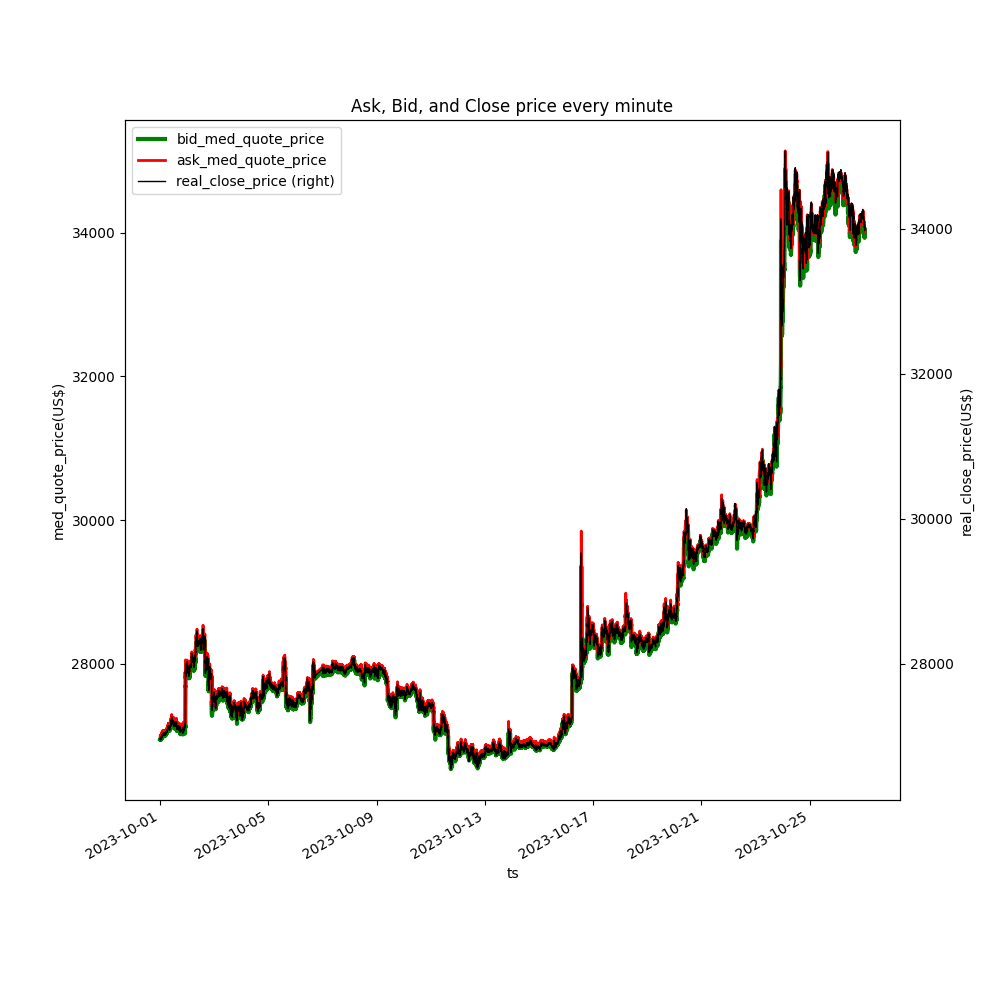

Text(0, 0.5, 'real_close_price(US$)')

In [4]:
# creating axes object and defining plot
ax = bid_ask_real_per_minute_df[["ts","bid_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'bid_med_quote_price', \
         color = 'Green', linewidth = 3)

ax2 = bid_ask_real_per_minute_df[["ts","ask_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'ask_med_quote_price', \
         color = 'Red', linewidth = 2, ax = ax)

ax3 = bid_ask_real_per_minute_df[["ts","real_close_price"]] \
    .plot(kind = 'line', x = 'ts', \
          y = 'real_close_price', secondary_y = True, \
          color = 'black',  linewidth = 1, ax = ax)

plt.title("Ask, Bid, and Close price every minute")
 

ax.set_xlabel('ts', color = 'black')
ax.set_ylabel('med_quote_price(US$)', color = "black")
ax3.set_ylabel('real_close_price(US$)', color = 'black')

In [7]:
######################
# Group by Second
######################

bid_ask_real_per_second_raw_df = spark.sql(
    """
        with avg_ask_quote_price_per_seqid as
        (
            select
                date_trunc('second', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'ask'
            group by
                ts_create_utc,
                seqid
        ),
        avg_bid_quote_price_per_seqid as
        (
            select
                date_trunc('second', ts_create_utc) as ts,
                seqid,
                avg(quote_price) as avg_quote_price,
                approx_percentile(quote_price, 0.5) as med_quote_price
            from 
                crypto_raw.order_book 
            where 
                id = 'BTC_USDT'
                and order_type = 'bid'
            group by
                ts_create_utc,
                seqid
        ),
        close_price_per_minute as
        (
            select 
                date_trunc('minute', ts_create_utc) as ts,
                close as real_close_price
            from 
                crypto_raw.candles_minute
            where
                id = 'BTC_USDT'
                and ts_create_utc >= (select min(ts_create_utc) from crypto_raw.market_trade)
        )
        select
            bid.ts,
            count(bid.avg_quote_price) as order_count,
            avg(bid.avg_quote_price) as bid_avg_quote_price,
            approx_percentile(bid.med_quote_price, 0.5) as bid_med_quote_price,
            avg(ask.avg_quote_price) as ask_avg_quote_price,
            approx_percentile(ask.med_quote_price, 0.5) as ask_med_quote_price,
            avg(_close.real_close_price) as real_close_price
        from 
            avg_bid_quote_price_per_seqid as bid
        left join 
            avg_ask_quote_price_per_seqid as ask
        on
            bid.ts = ask.ts
            and bid.seqid = ask.seqid
        left join
            close_price_per_minute as _close
        on
            bid.ts = _close.ts
        group by 
            1
        order by 
            1
    """
)

In [9]:
bid_ask_real_per_second_df = bid_ask_real_per_second_raw_df \
    .orderBy(['ts']) \
    .where(bid_ask_real_per_second_raw_df['ts'] >= '2023-10-01') \
    .toPandas()

bid_ask_real_per_second_df['real_close_price'] = bid_ask_real_per_second_df['real_close_price'].fillna(method='bfill')
bid_ask_real_per_second_df['real_close_price'] = bid_ask_real_per_second_df['real_close_price'].fillna(method='ffill')

bid_ask_real_per_second_df

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


,ts,order_count,bid_avg_quote_price,bid_med_quote_price,ask_avg_quote_price,ask_med_quote_price,real_close_price
0,2023-10-01 00:00:01,1,26944.211035,26942.449219,26984.626367,26984.269531,26962.130859
1,2023-10-01 00:00:04,1,26944.211035,26942.449219,26985.363867,26984.269531,26962.130859
2,2023-10-01 00:00:05,1,26942.819531,26940.000000,26985.363867,26984.269531,26962.130859
3,2023-10-01 00:00:06,5,26941.977813,26940.000000,26985.259648,26984.269531,26962.130859
4,2023-10-01 00:00:07,4,26942.421436,26942.449219,26984.715845,26984.269531,26962.130859
...,...,...,...,...,...,...,...
1862824,2023-10-27 01:00:16,6,33939.638086,33940.000000,34057.778613,34041.460938,34050.289062
1862825,2023-10-27 01:00:17,6,33939.638086,33940.000000,34057.636686,34040.398438,34050.289062
1862826,2023-10-27 01:00:18,6,33939.638086,33940.000000,34055.096354,34040.398438,34050.289062
1862827,2023-10-27 01:00:19,8,33939.638086,33940.000000,34056.942847,34040.398438,34050.289062


<IPython.core.display.Javascript object>


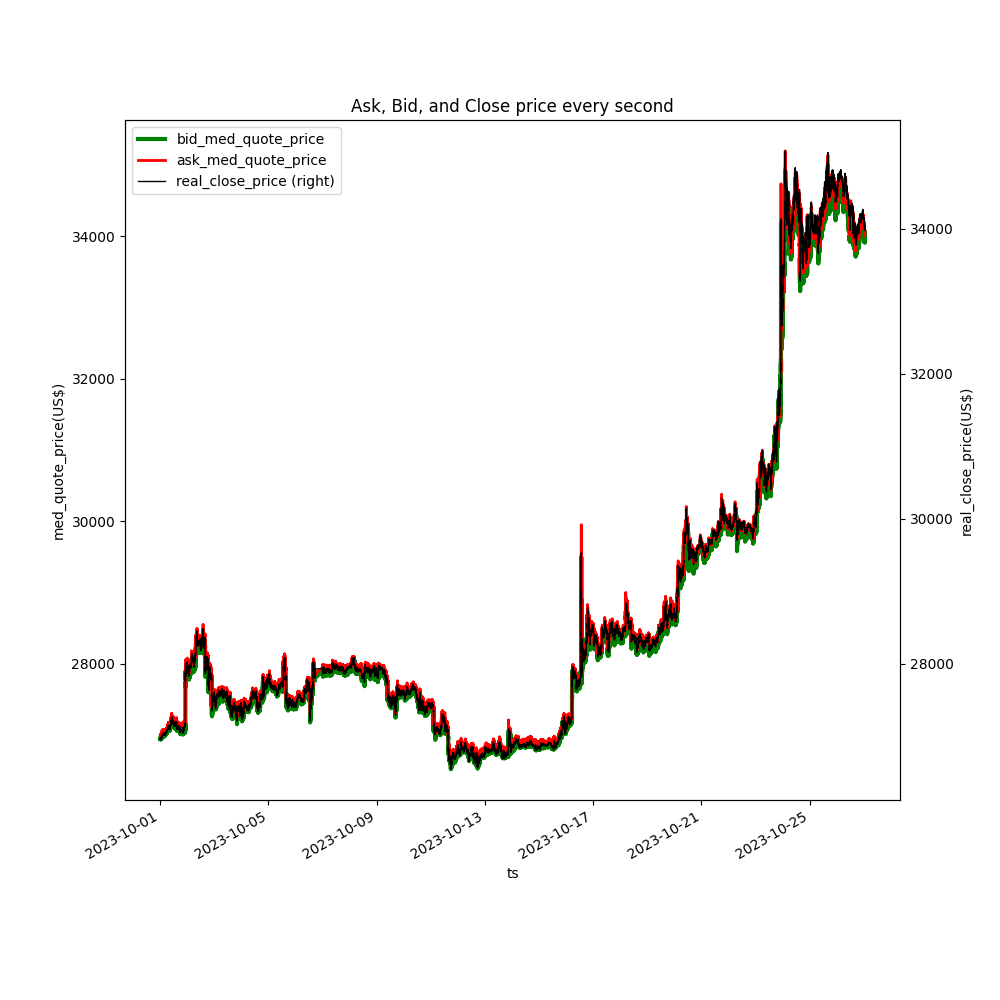

Text(0, 0.5, 'real_close_price(US$)')

In [10]:
# creating axes object and defining plot
ax = bid_ask_real_per_second_df[["ts","bid_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'bid_med_quote_price', \
         color = 'Green', linewidth = 3)

ax2 = bid_ask_real_per_second_df[["ts","ask_med_quote_price"]] \
    .plot(kind = 'line', x = 'ts', \
         y = 'ask_med_quote_price', \
         color = 'Red', linewidth = 2, ax = ax)

ax3 = bid_ask_real_per_second_df[["ts","real_close_price"]] \
    .plot(kind = 'line', x = 'ts', \
          y = 'real_close_price', secondary_y = True, \
          color = 'black',  linewidth = 1, ax = ax)
 
plt.title("Ask, Bid, and Close price every second")
 
ax.set_xlabel('ts', color = 'black')
ax.set_ylabel('med_quote_price(US$)', color = "black")
ax3.set_ylabel('real_close_price(US$)', color = 'black')